# Data Preprocessing

## 1. Data Description

The dataset is a collection of user reviews on YELP that were taken from a portion of the complete YELP Open data set approved for publication and was imported using the HuggingFace datasets library. Each record represents an individual review and has both structured and unstructured data. The main variable of interest is the review text, as it contains all of the written language contained in the review and it is used for performing a linguistic analysis. The variable (sentiment) that indicates how the user feels about the review indicates whether it is a positive or negative review along with a numerical representation of the review for use by a model (sentiment_id). Other pieces of information located in the dataset are a value rating of 1 through 5 (stars) assigned to each review, the user_id and author_id which are used to uniquely identify an author or reviewer. After discarding records that did not initially contain review or sentiment information, the dataset contains a large number of records with a strong bias toward positive reviews, which is common for online review sites and has an impact on how these reviews are used in subsequent analyses.

## 2. Setups and Imports

In [26]:
import re
import os
import numpy as np
import pandas as pd

from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt

## 3. Data Loading

In [27]:
from datasets import load_dataset
ds = load_dataset("ariazhan/yelp_review_uid")

In [28]:
ds["train"].select(range(10)).to_pandas()

,user_id,stars,author_id,review,sentiment,sentiment_id
0,_BcWyKQL16ndpBdggh2kNA,3,0,Got an estimate but went with another plumber ...,positive,1
1,_BcWyKQL16ndpBdggh2kNA,3,0,I like the Neuvo-Latino-Americano grub here. ...,positive,1
2,_BcWyKQL16ndpBdggh2kNA,5,0,Went for a casual happy hour and thoroughly en...,positive,1
3,_BcWyKQL16ndpBdggh2kNA,4,0,Wow - an overwhelming selection of products.\n...,positive,1
4,_BcWyKQL16ndpBdggh2kNA,4,0,We come to this Joann's when we can't get what...,positive,1
5,_BcWyKQL16ndpBdggh2kNA,4,0,"Better cookies!!! Try the Chinese ""Jewish Del...",positive,1
6,_BcWyKQL16ndpBdggh2kNA,4,0,Our 7 year old is a crafting wiz - albeit I am...,positive,1
7,_BcWyKQL16ndpBdggh2kNA,3,0,This is the City Nails in Penn Center - the ye...,positive,1
8,_BcWyKQL16ndpBdggh2kNA,4,0,I love TJ's and this location is no exception....,positive,1
9,_BcWyKQL16ndpBdggh2kNA,4,0,This is the location in the Pennsport Shopping...,positive,1


## 4. Data Cleaning and Label Definition

In [29]:
# Converting ds to df
df = ds["train"].to_pandas()

In [30]:
df = df.dropna(subset = ["review", "sentiment"]).copy()

In [31]:
# Normalize sentiment strings
df["sentiment"] = df["sentiment"].str.lower().str.strip()

In [32]:
# Keep only positive/negative if there are other labels
df = df[df["sentiment"].isin(["positive", "negative"])].copy()

In [33]:
# Binary label: 1 = positive, 0 = negative
df["y"] = (df["sentiment"] == "positive").astype(int)

In [34]:
df[["review", "sentiment", "y"]].head()

,review,sentiment,y
0,Got an estimate but went with another plumber ...,positive,1
1,I like the Neuvo-Latino-Americano grub here. ...,positive,1
2,Went for a casual happy hour and thoroughly en...,positive,1
3,Wow - an overwhelming selection of products.\n...,positive,1
4,We come to this Joann's when we can't get what...,positive,1


## 5. EDA: Class balance

In [35]:
df["sentiment"].value_counts(normalize = True)

sentiment
positive    0.927607
negative    0.072393
Name: proportion, dtype: float64

### 5.1 Check label distribution (counts + proportions)

In [36]:
counts = df["sentiment"].value_counts()
props = df["sentiment"].value_counts(normalize = True)

display(pd.DataFrame({"count": counts, "proportion": props}))

# Quick text summary
pos_rate = props.get("positive", np.nan)
neg_rate = props.get("negative", np.nan)
print(f"Positive rate: {pos_rate:.4f}, Negative rate: {neg_rate:.4f}")

,count,proportion
sentiment,,
positive,16081,0.927607
negative,1255,0.072393


Positive rate: 0.9276, Negative rate: 0.0724


### 5.2 Visualize class imbalance

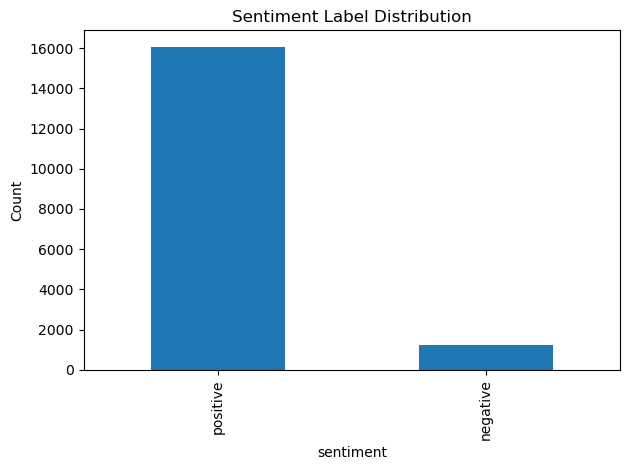

In [37]:
plt.figure()
counts.plot(kind = "bar")
plt.title("Sentiment Label Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("outputs/class_balance.png", dpi = 200)
plt.show()

### 5.3 Review length (words + chars) by sentiment

In [38]:
df["n_words"] = df["review"].astype(str).str.split().str.len()
df["n_chars"] = df["review"].astype(str).str.len()

display(df.groupby("sentiment")[["n_words", "n_chars"]].describe().round(2))

n_words                                                  n_chars  \
             count    mean     std  min   25%    50%    75%    max    count   
sentiment                                                                     
negative    1255.0  170.32  117.02  1.0  86.0  141.0  227.0  959.0   1255.0   
positive   16081.0  183.42  121.84  1.0  96.0  154.0  241.0  938.0  16081.0   

                                                               
             mean     std   min    25%    50%     75%     max  
sentiment                                                      
negative   914.83  632.27   7.0  458.0  754.0  1225.5  5000.0  
positive   992.75  665.46  11.0  519.0  826.0  1298.0  4999.0

<Figure size 640x480 with 0 Axes>

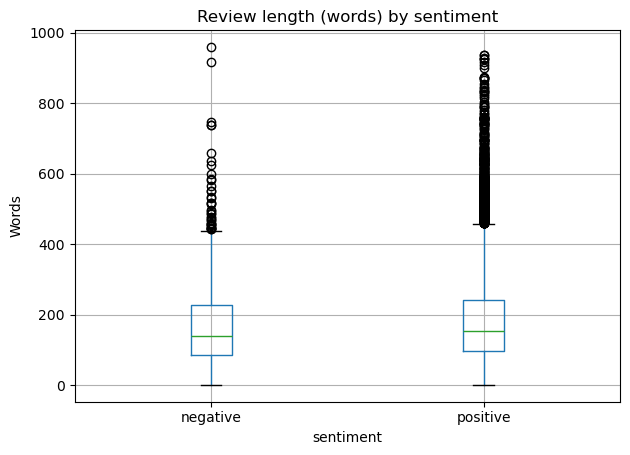

In [39]:
plt.figure()
df.boxplot(column = "n_words", by = "sentiment")
plt.title("Review length (words) by sentiment")
plt.suptitle("")
plt.ylabel("Words")
plt.tight_layout()
plt.savefig("outputs/review_length_words_by_sentiment.png", dpi = 200)
plt.show()

<Figure size 640x480 with 0 Axes>

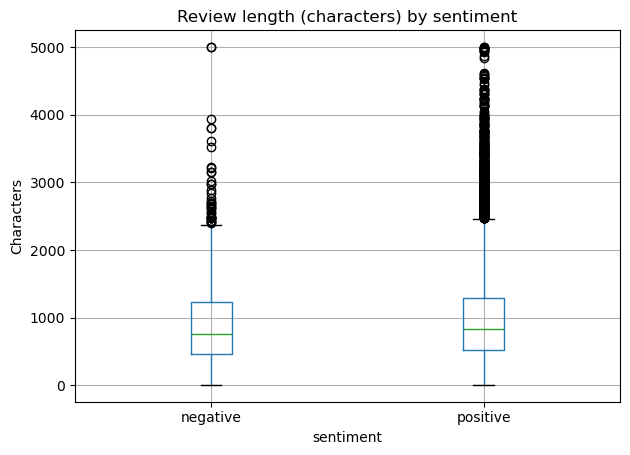

In [40]:
plt.figure()
df.boxplot(column = "n_chars", by = "sentiment")
plt.title("Review length (characters) by sentiment")
plt.suptitle("")
plt.ylabel("Characters")
plt.tight_layout()
plt.savefig("outputs/review_length_chars_by_sentiment.png", dpi = 200)
plt.show()

### 5.4 Create a balanced analysis subset for interpretability

In [41]:
df_pos = df[df["sentiment"] == "positive"]
df_neg = df[df["sentiment"] == "negative"]

n = min(len(df_neg), len(df_pos))  # will be len(df_neg)
df_bal = pd.concat([
    df_pos.sample(n=n, random_state=42),
    df_neg.sample(n=n, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

df_bal["sentiment"].value_counts()

sentiment
negative    1255
positive    1255
Name: count, dtype: int64

Key Note: The dataset is highly imbalanced (~93% positive). In modeling, we will use stratified splits and class weighting to avoid trivial majority-class predictions.

## 6. Text Preprocessing

In [42]:
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)          # URLs
    s = re.sub(r"<.*?>", " ", s)                    # HTML tags
    s = re.sub(r"\s+", " ", s).strip()              # extra whitespace
    return s

df["text"] = df["review"].astype(str).apply(clean_text)
df[["review", "text"]].head()

,review,text
0,Got an estimate but went with another plumber ...,got an estimate but went with another plumber ...
1,I like the Neuvo-Latino-Americano grub here. ...,i like the neuvo-latino-americano grub here. t...
2,Went for a casual happy hour and thoroughly en...,went for a casual happy hour and thoroughly en...
3,Wow - an overwhelming selection of products.\n...,wow - an overwhelming selection of products. t...
4,We come to this Joann's when we can't get what...,we come to this joann's when we can't get what...


## 7. Train/Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["y"],
    test_size=0.2,
    random_state=42,
    stratify=df["y"]
)

len(X_train), len(X_test)

(13868, 3468)

## 8. Feature Extraction (TF-IDF with unigrams + bigrams)

In [44]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),     # unigrams + bigrams (phrases)
    min_df=5,               # ignore super-rare terms
    max_df=0.9,             # ignore super-common terms
    stop_words="english",   # simple baseline
)

Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

Xtr.shape, Xte.shape

((13868, 37347), (3468, 37347))

## 9. Train a Simple Linear Model (Logistic Regression)

In [45]:
clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(Xtr, y_train)

pred = clf.predict(Xte)
proba = clf.predict_proba(Xte)[:, 1]

print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))

              precision    recall  f1-score   support

           0       0.48      0.68      0.56       251
           1       0.97      0.94      0.96      3217

    accuracy                           0.92      3468
   macro avg       0.73      0.81      0.76      3468
weighted avg       0.94      0.92      0.93      3468

ROC-AUC: 0.9302324429357485


In [46]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 170,   81],
       [ 186, 3031]])

## 10. Interpretability: Top Words/Phrases that Separate Positive vs Negative

In [47]:
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]  # positive coef => pushes toward positive class

top_k = 30

top_pos_idx = np.argsort(coefs)[-top_k:][::-1]
top_neg_idx = np.argsort(coefs)[:top_k]

top_pos = pd.DataFrame({
    "term": feature_names[top_pos_idx],
    "coef": coefs[top_pos_idx]
})

top_neg = pd.DataFrame({
    "term": feature_names[top_neg_idx],
    "coef": coefs[top_neg_idx]
})

top_pos.head(10), top_neg.head(10)

(        term      coef
 0       good  4.742350
 1      great  4.659690
 2  delicious  4.582719
 3       love  4.119681
 4        bit  3.571624
 5  excellent  3.430057
 6    perfect  3.282126
 7   friendly  3.254213
 8    amazing  3.044942
 9    enjoyed  2.969685,
        term      coef
 0    better -4.698981
 1     sorry -4.585387
 2       meh -4.557905
 3  mediocre -4.546105
 4     awful -4.324821
 5      just -4.291262
 6      left -4.008141
 7     cheap -3.821438
 8       bad -3.521364
 9     worst -3.458821)

In [48]:
top_pos.to_csv("outputs/top_positive_terms.csv", index=False)
top_neg.to_csv("outputs/top_negative_terms.csv", index=False)

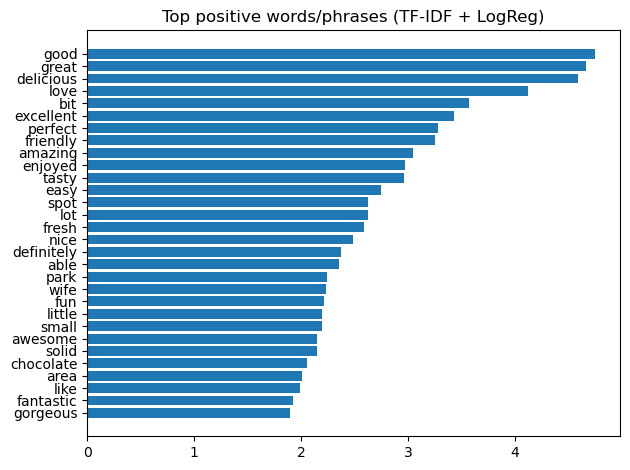

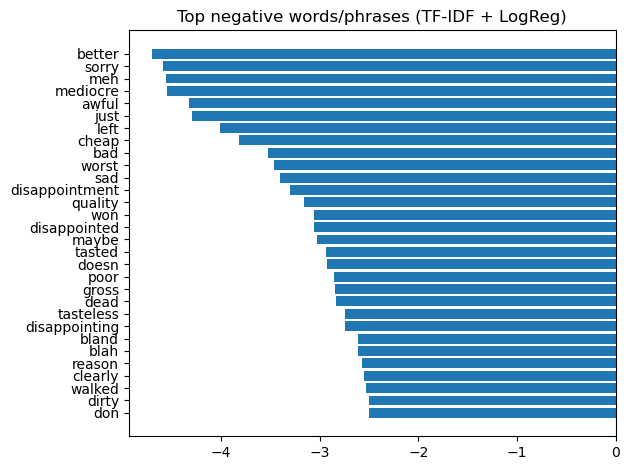

In [49]:
# Plot top coefficients
plt.figure()
plt.barh(top_pos["term"][::-1], top_pos["coef"][::-1])
plt.title("Top positive words/phrases (TF-IDF + LogReg)")
plt.tight_layout()
plt.savefig("outputs/top_positive_terms.png", dpi=200)
plt.show()

plt.figure()
plt.barh(top_neg["term"][::-1], top_neg["coef"][::-1])
plt.title("Top negative words/phrases (TF-IDF + LogReg)")
plt.tight_layout()
plt.savefig("outputs/top_negative_terms.png", dpi=200)
plt.show()

## 11. Analysis Result

Our initial review of the Yelp dataset shows a significant imbalance in sentiment, with roughly 92.8% of reviews being positive and 7.2% being negative. Most reviewers tend to give positive feedback. This significant difference in the amount of positive vs. negative reviews could drastically impact future analysis of this dataset. For instance, callbacks for over-generalized classifiers may yield very high accuracy rates with only using the majority class as a prediction. Therefore, in order to minimize this imbalance by creating an equally represented balanced subset for our interpretive analyses and by employing logistic regression weighted according to class.

The findings from analysis of the review length suggest that there is an indication that the average positive review is longer than a negative review. In particular, the average word length in the average positive review is about 183 words, whereas the average word length in a negative review is approximately 170 words. With respect to characters, a similar finding exists as exemplified by the similarity in boxplots; there appears to be a large overlap between the two distributions, suggesting that review length may not be a strong distinguishing characteristic between sentiment classification. The long right tails of each distribution suggest that several very long positive and negative reviews are contained within both review classifications.

In order to neutralize the extreme class imbalance in our analysis of linguistic features, we create a balanced dataset containing equal amounts of positive and negative reviews. This allows us to focus on identifying the linguistic characteristics of both positive and negative sentiment rather than just identifying the linguistic characteristics that are representative of class frequency.

Using a logistic regression model which utilized unigrams and bigram features calculated using term frequency inverse document frequency (TF-IDF) resulted in a high degree of accuracy as indicated by an area under the curve (AUC) score of approximately 0.93; however, the confusion matrix and classification report demonstrate an unequal distribution of performance across classification levels suggesting that while nearly 100% of the positive reviews were correctly classified, this same level of classification accuracy for the negative reviews was not achieved by the model likely due to some remaining issues associated with the initial imbalance of training examples between the positive and negative classes and also because predicting negative reviews tends to be more challenging than for positive reviews.

Most importantly, the model coefficients provide clear and interpretable insights into sentiment-driven language use. The strongest positive coefficients correspond to clearly positive evaluative terms such as “good,” “great,” “delicious,” “love,” “excellent,” and “amazing,” which align with intuitive expressions of satisfaction. In contrast, the strongest negative coefficients are associated with words such as “sorry,” “meh,” “mediocre,” “awful,” “worst,” “disappointed,” and “bad,” which capture negative judgment. Interestingly, some words like “better” appear among negative indicators, likely reflecting comparative complaints (e.g., “it used to be better”), highlighting the importance of contextual interpretation.

Overall, these results demonstrate that simple lexical features, when appropriately weighted, strongly differentiate positive and negative Yelp reviews. While review length provides some signal, sentiment is driven primarily by explicit evaluative language and affective cues, which are effectively captured by TF-IDF representations and linear models. This analysis establishes a clear linguistic foundation for understanding sentiment differences and motivates further exploration using more context-aware models.